In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
import os

# Drive mounting and data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/CIS\ 602 /project
!ls /project/UTKFace

part1  part1.zip  part2  part2.zip  part3  part3.zip  part4  part4.zip


In [ ]:
!unzip "/project/UTKFace/part1.zip" -d "/content"
!unzip "/project/UTKFace/part2.zip" -d "/content"
!unzip "/project/UTKFace/part3.zip" -d "/content"
!unzip "/project/UTKFace/part4.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/part4/49_1_0_20170109142119876.jpg.chip.jpg  
  inflating: /content/part4/49_1_0_20170109142131660.jpg.chip.jpg  
  inflating: /content/part4/49_1_0_20170109220421978.jpg.chip.jpg  
  inflating: /content/part4/49_1_0_20170109220426712.jpg.chip.jpg  
  inflating: /content/part4/49_1_0_20170109220434368.jpg.chip.jpg  
  inflating: /content/part4/49_1_0_20170109220611995.jpg.chip.jpg  
  inflating: /content/part4/49_1_0_20170109220635624.jpg.chip.jpg  
  inflating: /content/part4/49_1_0_20170109220855652.jpg.chip.jpg  
  inflating: /content/part4/49_1_0_20170109221050190.jpg.chip.jpg  
  inflating: /content/part4/49_1_0_20170109221102358.jpg.chip.jpg  
  inflating: /content/part4/49_1_0_20170109221146542.jpg.chip.jpg  
  inflating: /content/part4/49_1_0_20170110125307207.jpg.chip.jpg  
  inflating: /content/part4/49_1_0_20170110141243521.jpg.chip.jpg  
  inflating: /content/part4/49_1_0_20170110154336582.jpg.chip.jpg

# Method defination for data transformation, splitting and model training.

In [ ]:
def data_load_and_model_fitting(model, data_paths, label):
  data = []
  labels = []
  print('Loading Images...')
  i = 0
  # loop over the image paths
  for data_path in data_paths:
    for images in os.listdir(data_path):
      i+=1
      image_name = os.path.split(images)[1]
      image_name = os.path.splitext(image_name)[0]
      image_parts = image_name.split('_')
      if len(image_parts) == 4:
        image = load_img(data_path+images, target_size=(198, 198))
        image = img_to_array(image)
        image = preprocess_input(image)
        # update the data and labels lists, respectively
        data.append(image)
        if 'g' == label:
          labels.append(image_parts[1])
        elif 'e' == label:
          labels.append(image_parts[2])
        else:
          raise Exception('None recognizable label')


  print('Loaded total',i,'images.')

  # Data conversion and splitting
  data = np.array(data, dtype="float32")
  labels = np.array(labels)
  labels = LabelBinarizer().fit_transform(labels)

  (trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)
  
  aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")
  print("[INFO] training Model...")
  
  history = model.fit(
      aug.flow(trainX, trainY, batch_size=20),
      validation_data=(testX, testY),
      epochs=20, callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1)])
  
  # Plot the accuracy and los improvement in graph to show how well model is getting trained on.
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.plot(history.history['acc'], label='Training Accuracy')
  plt.plot(history.history['val_acc'], label='Validation Accuracy')
  plt.ylabel('Value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper right")
  plt.show()
  return model

# Base Model for Ethnicity and Gender

In [2]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(198, 198, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)

# for layer in baseModel.layers:
#     layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [3]:
INIT_LR = 1e-4
EPOCHS = 20

# Optimizer
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

# Ethnicity Model Compiling

## Part 1 and 2 training

In [5]:
# Ethnicity model
ethnicity_model = Dense(5, activation="softmax")(headModel)

ethnicity_model = Model(inputs=baseModel.input, outputs= ethnicity_model)

In [6]:
ethnicity_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 198, 198, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 99, 99, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 99, 99, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
print("[INFO] compiling model...")
# loss="sparse_categorical_crossentropy"
loss="categorical_crossentropy"
ethnicity_model.compile(loss=loss, optimizer=opt,
    metrics=["acc"])

[INFO] compiling model...


[INFO] training Ethnicity Model for part 1...
Loading Images...
Loaded total 9960 images.
[INFO] training Model...
Epoch 1/20
399/399 [==============================] - 125s 221ms/step - loss: 1.2984 - acc: 0.5051 - val_loss: 1.1832 - val_acc: 0.5773
Epoch 2/20
399/399 [==============================] - 85s 213ms/step - loss: 0.8581 - acc: 0.6982 - val_loss: 1.4644 - val_acc: 0.5964
Epoch 3/20
399/399 [==============================] - 85s 213ms/step - loss: 0.7686 - acc: 0.7238 - val_loss: 1.3538 - val_acc: 0.6165
Epoch 4/20
399/399 [==============================] - 85s 212ms/step - loss: 0.6826 - acc: 0.7571 - val_loss: 1.1440 - val_acc: 0.6822
Epoch 5/20
399/399 [==============================] - 85s 213ms/step - loss: 0.6097 - acc: 0.7859 - val_loss: 0.8181 - val_acc: 0.7681
Epoch 6/20
399/399 [==============================] - 85s 213ms/step - loss: 0.5813 - acc: 0.7963 - val_loss: 0.6022 - val_acc: 0.8042
Epoch 7/20
399/399 [==============================] - 85s 212ms/step - los

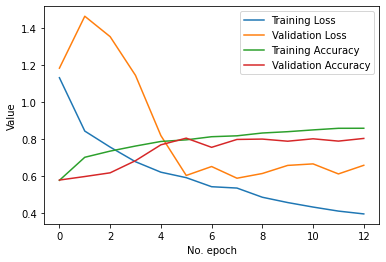

In [ ]:
print("[INFO] training Ethnicity Model for part 1...")
ethnicity_model = data_load_and_model_fitting(ethnicity_model,{'/content/part1/','/content/part2/'},'e')

In [ ]:
ethnicity_model.save("ethnicity_Model12.h5")

## Part 4 training

In [ ]:
ethnicity_model = load_model("ethnicity_Model12.h5")

[INFO] training Ethnicity Model for part 4/3...
Loading Images...
Loaded total 6920 images.
[INFO] training Model...
Epoch 1/20
277/277 [==============================] - 94s 220ms/step - loss: 0.5930 - acc: 0.8206 - val_loss: 0.5580 - val_acc: 0.8338
Epoch 2/20
277/277 [==============================] - 59s 212ms/step - loss: 0.4756 - acc: 0.8466 - val_loss: 0.5594 - val_acc: 0.8432
Epoch 3/20
277/277 [==============================] - 59s 213ms/step - loss: 0.4278 - acc: 0.8592 - val_loss: 0.6334 - val_acc: 0.8324
Epoch 4/20
277/277 [==============================] - 59s 213ms/step - loss: 0.3932 - acc: 0.8746 - val_loss: 0.7986 - val_acc: 0.8208
Epoch 5/20
277/277 [==============================] - 59s 213ms/step - loss: 0.3678 - acc: 0.8804 - val_loss: 0.7391 - val_acc: 0.8186
Epoch 6/20
277/277 [==============================] - 59s 213ms/step - loss: 0.3375 - acc: 0.8876 - val_loss: 0.6263 - val_acc: 0.8374
Epoch 00006: early stopping


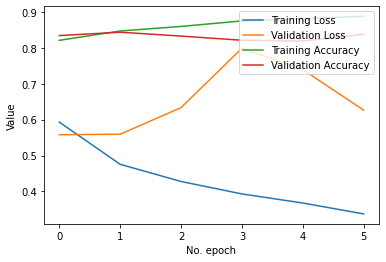

In [ ]:
print("[INFO] training Ethnicity Model for part 4/3...")
ethnicity_model = data_load_and_model_fitting(ethnicity_model,{'/content/part4/'},'e')

In [ ]:
ethnicity_model.save("ethnicity_Model124.h5")

## Part 3 training

In [ ]:
# ethnicity_model = load_model("ethnicity_Model124.h5")

[INFO] training Ethnicity Model for part 3...
Loading Images...
Loaded total 6828 images.
[INFO] training Model...
Epoch 1/20
274/274 [==============================] - 62s 221ms/step - loss: 0.7560 - acc: 0.7464 - val_loss: 0.6668 - val_acc: 0.7848
Epoch 2/20
274/274 [==============================] - 59s 215ms/step - loss: 0.6421 - acc: 0.7735 - val_loss: 0.5720 - val_acc: 0.8119
Epoch 3/20
274/274 [==============================] - 59s 212ms/step - loss: 0.5938 - acc: 0.7902 - val_loss: 0.6113 - val_acc: 0.7950
Epoch 4/20
274/274 [==============================] - 60s 216ms/step - loss: 0.5454 - acc: 0.8122 - val_loss: 0.6221 - val_acc: 0.8038
Epoch 5/20
274/274 [==============================] - 60s 216ms/step - loss: 0.5365 - acc: 0.8178 - val_loss: 0.5509 - val_acc: 0.8126
Epoch 6/20
274/274 [==============================] - 59s 215ms/step - loss: 0.4907 - acc: 0.8255 - val_loss: 0.6061 - val_acc: 0.7994
Epoch 7/20
274/274 [==============================] - 60s 216ms/step - loss

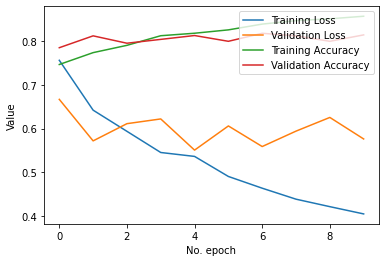

In [ ]:
print("[INFO] training Ethnicity Model for part 3...")
ethnicity_model = data_load_and_model_fitting(ethnicity_model,{'/content/part3/'},'e')

In [ ]:
ethnicity_model.save("ethnicity_Model_final.h5")